# Когортный анализ: окупаемость рекламных кампаний

<font color="DarkCyan"> что тут есть: выделение профилей пользователей, функции и анализ метрик RR, CR, LTV, ROI в контексте пользователей приложения, анализ метрик в разрезе когорт, расчет скользящего среднего, построение нескольких графиков на 1 полотне в matplotlib (функции на визуализацию метрик)

**Вводная: необходимо проанализировать окупаемость рекламных кампаний, проходивших в период с мая по октябрь 2019. <br>Как будем это делать:**
    
> - предобработаем данные от заказчика
> - напишем функции для расчета метрик и их визуализации (оставлены комментарии к логике работы)
> - проведем аналитику и дадим рекомендации отделу маркетинга

### Предобработка данных от заказчика

**Загрузим основные библиотеки, объявим переменные с датасетами заказчика:**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from datetime import datetime, timedelta

Заказчик предоставил 3 датасета с логами посещений пользователей, заказами пользователей и стоимостью привлечения в рекламном канале (visits, orders и costs):

In [2]:
visits = pd.read_csv('visits_info_short-1.csv')
orders = pd.read_csv('orders_info_short-1.csv')
costs = pd.read_csv('costs_info_short-1.csv')

Посмотрим "шапки" таблиц и общей информации о датасетах:

In [3]:
def inform(visits, orders, costs):
    for df in [visits, orders, costs]:
        display(df.head(1))
        df.info()

In [4]:
inform(visits, orders, costs)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [5]:
# переименуем столбцы
# альтернатива: цикл df.columns = [df.lower().replace(' ', '_') for x in df.columns]
visits.columns = ['id', 'region', 'device', 'channel', 'sess_start_dt', 'sess_end_dt']
orders.columns = ['id', 'order_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

In [6]:
# предобработаем даты
visits['sess_start_dt'] = pd.to_datetime(visits['sess_start_dt'])
visits['sess_end_dt'] = pd.to_datetime(visits['sess_end_dt'])
orders['order_dt'] = pd.to_datetime(orders['order_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [7]:
# проверим дубликаты
visits.duplicated().sum() + orders.duplicated().sum() + costs.duplicated().sum()

0

**Закончили предобработку данных:**
<br> - убедились, что в данных нет пропусков путем просмотра общей инфо о датасетах
<br> - заменили названия колонок на версии в хорошем тоне
<br> - заменили тип дат в тех столбцах, где это требовалось
<br> - убедились, что ни в 1 датафрейме нет полностью одинаковых строк (сложили кол-во дубликатов во всех 3 датафреймах, сумма = 0)

### Создание функций для расчёта и визуализации метрик

#### **get_prof() - функция для создания профилей пользователей**
Создает новый сет на выходе, в котором остаются данные по первому входу пользователя.
<br>В новый сет добавляет столбцы с датой когорты (отсекли время), месяцем 1го входа и признаком платящего (признак присваивается, если id юзера присутствует в таблице заказов).
<br>Дополнительно присоединяем данные по тому, сколько стоит пользователь, пришедший в дату когорты + через первый канал юзера (делим общие затраты на канал в эту дату на кол-во уникальных пользователей, впервые пришедших в эту дату в канал)

In [8]:
# 0 - профили пользователей
def get_prof(visits, orders, costs):
    # параметры первого посещения юзера
    profiles = (visits.sort_values(by=['id', 'sess_start_dt'])
                .groupby('id')
                .agg({'sess_start_dt': 'first',
                      'region': 'first',
                      'device': 'first',
                      'channel': 'first'})
                .rename(columns={'sess_start_dt': 'first_ts'})
                .reset_index())
    # добавляем поля с датой и месяцем входа клиента, а также поле с признаком платящего юзера
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.month
    profiles['payer'] = profiles['id'].isin(orders['id'].unique())
    
    # считаем стоимость привлечения в рамках даты / канала привлечения
    new_users = (profiles.groupby(['dt', 'channel'])
                 .agg({'id': 'nunique'})
                 .rename(columns={'id': 'unique_users'})
                 .reset_index())
    
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    costs['user_cost'] = costs['costs'] / costs['unique_users']
    
    # джойним стоимость к каждому юзеру в рамках даты / канала привлечения в сете профилей (зануляем органический трафик)
    profiles = profiles.merge(costs[['dt', 'channel', 'user_cost']], on=['dt', 'channel'], how='left')
    profiles['user_cost'] = profiles['user_cost'].fillna(0)
    
    return profiles   

<font color="DarkCyan">

**Прим: для функций расчета RR, CR, LTV/ROI добавляем доп.признак - игнорировать ли органических пользователей (ignore_organic, по умолчанию установлено значение False)**

In [9]:
demo_1 = get_prof(visits, orders, costs)
demo_1.head(1)

,id,first_ts,region,device,channel,dt,month,payer,user_cost
0,599326,2019-05-07 20:58:57,United States,Mac,FaceBoom,2019-05-07,5,True,1.088172


#### **get_rr() - функция для расчёта retention_rate**
<br> Считаем RR на основе датасета профилей (б. рассчитан предыдущей функцией), датасета с логами посещений приложения, уровней, по которым будем группировать когорты, даты наблюдения (= откуда смотрим, в дальнейшем будем ставить туда максимальную дату, указанную в датасете заказчика) и горизонта анализа, по который будем считать RR.
<br> Также ставим 2 условия в аргументы - игнорирование горизонта событий 
>- В уровни по умолчанию ставим в группировку когорт признак платящего (payer). Если в levels не установим ничего, то когорты разделятся только по этому признаку
>- Добавляем условие, что в случае, если мы не игнорируем горизонт событий (if not False == True), в этом случае последняя подходящая для нас дата = дата анализа минус кол-во дней горизонта (вычитаем 1, тк нумерация идет с нуля). В этом случае датасет профилей фильтруется, отсекая юзеров, которые пришли позже последней подходящей даты и не прожили весь горизонт событий (к примеру полные 7 дней)
>- Если установлено условие отсекать юзеров, пришедших с органики, датасет дополнительно фильтруется следующим условием (органика не особо релеватна для анализа рекламных кампаний)
>- Джойним к (не)отфильтрованному сету профилей визиты и высчитываем лайфтайм каждого визита в кол-ве дней. Получаем сырую таблицу rr_raw
>- Создаем внутреннюю функцию group_rr_lev, которая будет: 1) группировать датасет по уровням, собирая сводную с кол-вом уникальных id + по колонкам лайфтайма; 2) собирать датасет с когортами с кол-м id в каждом уровне; 3) джойнить созданные 2 датасета (merge по уровням) + заполнять пустые значения кол-в id нулями; 4) рассчитывать ретеншн рэйт по каждому лайфтайму, через div()  деля значение ячейки на размер когорты этой строки; 5) "отрезать" колонки лайтайма, большие чем значение горизонта анализа (-1 из-за нумерации индексов, т.е. лайфтайм == 0 на деле это 1-й день); 6) подменять значение столбца cohort_size датасетов когорт (тк после div оно стало равно 1)
>- Итого с предыдущей функции получаем еще 2 финальных выходных датасета: сгруппированный по заданным уровням + он же, дополнительно сгруппированный по датам когорт

In [10]:
def get_rr(profiles, visits, obs_dt, horizon, levels=[], ignore_horizon=False, ignore_organic=False):
    
    # по умолчанию добавляем в levels признак платящего юзера
    levels = ['payer'] + levels
    
    # исключаем юзеров, не доживших до горизонта анализа
    last_suit_dt = obs_dt
    if not ignore_horizon:
        last_suit_dt = obs_dt - timedelta(days=horizon - 1)
    rr_raw = profiles.query('dt <= @last_suit_dt')
    
    if ignore_organic: # добавляем условие выкидывать органику из сырого RR, если ignore_organic=True
        rr_raw = rr_raw.query('channel != "organic"')
    
    # джойним к профилям визиты клиентов, добавляем расчетный столбец с лайфтаймом
    rr_raw = rr_raw.merge(visits[['id', 'sess_start_dt']], on='id', how='left')
    rr_raw['lifetime'] = (rr_raw['sess_start_dt'] - rr_raw['first_ts']).dt.days
    
    # создаем функцию для группировки по признакам
    def group_rr_lev(df, levs, horizon):
        rr_lev = df.pivot_table(index=levs, columns='lifetime', values='id', aggfunc='nunique')
        cohorts = (df.groupby(levs)
                   .agg({'id': 'nunique'})
                   .rename(columns={'id': 'cohort_size'}))
        # создаем на выходе таблицу, которая будет собирать RR по заданным измерениям когорт
        rr_lev = cohorts.merge(rr_lev, on=levs, how='left').fillna(0)
        rr_lev = rr_lev.div(rr_lev['cohort_size'], axis=0)
        rr_lev = rr_lev[['cohort_size'] + list(range(horizon))]
        rr_lev['cohort_size'] = cohorts
        
        return rr_lev
    
    # получаем таблицу удержания по когортам и таблицу динамикм удержания
    rr_group = group_rr_lev(rr_raw, levels, horizon)
    rr_in_time = group_rr_lev(rr_raw, levels+['dt'], horizon)
    
    return rr_raw, rr_group, rr_in_time

при установке ignore_horizon==True в rr_raw не отрезаются даты горизонта анализа (по 27/10 тотал будет все включено), rr_group вообще будет не совсем корректной (тк в когорте не все "дожили" до лайфтайма, а нули также будут учитываться в числителе и значение RR последних дней будет занижено по этой причине), а в rr_in_time будут нулевые значения как раз в последних днях

In [11]:
obs_dt = datetime(2019, 10, 27).date() #момент анализа
horizon = 7 # горизонт анализа

demo_21, demo_22, demo_23 = get_rr(demo_1, visits, obs_dt, horizon, ignore_horizon=False)

rr_rawy, rr_groupy, rr_in_timey = get_rr(demo_1, visits, obs_dt, horizon, ignore_horizon=True)
display(demo_21.sort_values(by=['id', 'first_ts']).tail(1))
display(rr_rawy.sort_values(by=['first_ts', 'id']).tail(1))
display(demo_22.head(1))
display(rr_groupy.head(1))
display(demo_23.tail(1))
display(rr_in_timey.tail(1))

,id,first_ts,region,device,channel,dt,month,payer,user_cost,sess_start_dt,lifetime
300876,999999563947,2019-10-18 19:57:25,United States,iPhone,organic,2019-10-18,10,False,0.0,2019-10-20 04:10:34,1


,id,first_ts,region,device,channel,dt,month,payer,user_cost,sess_start_dt,lifetime
229460,739432831998,2019-10-27 23:59:04,United States,iPhone,TipTop,2019-10-27,10,False,3.458824,2019-10-27 23:59:04,0


,cohort_size,0,1,2,3,4,5,6
payer,,,,,,,,
False,135866,1.0,0.176704,0.086357,0.051455,0.034549,0.024568,0.018518


,cohort_size,0,1,2,3,4,5,6
payer,,,,,,,,
False,141127,1.0,0.176827,0.086319,0.051528,0.034409,0.024304,0.018161


,,cohort_size,0,1,2,3,4,5,6
payer,dt,,,,,,,,
True,2019-10-21,48,1.0,0.458333,0.375,0.3125,0.375,0.1875,0.229167


,,cohort_size,0,1,2,3,4,5,6
payer,dt,,,,,,,,
True,2019-10-27,67,1.0,0.373134,0.313433,0.208955,0.089552,0.0,0.0


<!-- # здесь горизонт отсекает тех кто не дожил / те кто не дожил имеют зануоенный RR -->

#### **get_rr() - функция для расчёта conversion_rate**
<br> Набор входных аргументов ~аналогичен функции RR. Из особенностей:
>- создаем сет с 1м заказом, чтобы дополнить датой 1го заказа сет с профилями (cr_raw)
>- добавляем столбец с исчислением лайфтайма, на который была сделана покупка
>- здесь не нужна группировка по платящим, и levels могут быть пустыми. Чтобы функция не вылетала в ошибку, в случае пустых уровней добавляем доп. столбец all_cohorts, и группируем по нему
>- создаем внутреннюю функцию группировки, в которой: 1) делаем сводную с группировкой по уровням и лайфтаймом в колонках, считаем кол-во сконвертированных юзеров; 2) рассчитываем конверсию покупок с накоплением в разрезе когорт и лайфтаймов (CR всегда растет); 3) создаем сет с кол-вом юзеров в разрезе заданных когорт; 4) джойним к размеру когорт кол-во сконвертированных юзеров и через div() рассчитываем конверсию каждого лайфтайма; 5) отрезаем сет по столбец с горизонтом анализа (list(range(5) вернет список [0,1,2,3,4]); 6) возвращаем колонку с размером когорт 
>- если в возвращенном сете только группировка по когортам (all_cohorts) - убираем этот столбец за ненадобностью из сета с конверсией по дням

In [12]:
def get_cr(profiles, orders, obs_dt, horizon, levels=[], ignore_horizon=False, ignore_organic=False):
    
    # исключаем юзеров, не доживших до горизонта анализа
    last_suit_dt = obs_dt
    if not ignore_horizon:
        last_suit_dt = obs_dt - timedelta(days=horizon - 1)
    cr_raw = profiles.query('dt <= @last_suit_dt')
    
    if ignore_organic: # добавляем условие выкидывать органику из сырого CR, если ignore_organic=True
        cr_raw = cr_raw.query('channel != "organic"')
    
    # создаем сет с первыми покупками юзеров
    first_order = (orders.sort_values(by=['id', 'order_dt'])
                   .groupby('id')
                   .agg({'order_dt': 'first'})
                   .rename(columns={'order_dt': 'first_order_dt'})
                   .reset_index())
    
    # к профилям джойним сет с первой покупкой, создаем столбец с лайфтаймом покупки
    cr_raw = cr_raw.merge(first_order, on='id', how='left')
    cr_raw['lifetime'] = (cr_raw['first_order_dt'] - cr_raw['first_ts']).dt.days
    
    # добавляем условие группировки, если levels пустые
    if len(levels) == 0:
        cr_raw['cohort'] = 'all_users'
        levels = levels + ['cohort']
    
    # создаем функцию для группировки по признакам
    def group_cr_lev(df, levs, horizon):
        cr_lev = df.pivot_table(index=levs, columns='lifetime', values='id', aggfunc='nunique')
        # рассчитываем кол-во с накоплением по лайфтаймам в рамках заданных признаков
        cr_lev = cr_lev.fillna(0).cumsum(axis=1) 
        # создаем сет с когортами по признакам
        cohorts = (df.groupby(levs)
                   .agg({'id': 'nunique'})
                   .rename(columns={'id': 'cohort_size'}))
        # джойним к нему сет с накопленим сконвертированных юзеров по дням. Получаем конверсию каждого дня через div()
        cr_lev = cohorts.merge(cr_lev, on=levs, how='left').fillna(0)
        cr_lev = cr_lev.div(cr_lev['cohort_size'], axis=0)
        cr_lev = cr_lev[['cohort_size'] + list(range(horizon))]
        cr_lev['cohort_size'] = cohorts
        
        return cr_lev
    
    # таблица конверсии
    cr_group = group_cr_lev(cr_raw, levels, horizon)
    
    # для cr_in_time убираем 'cohort' из levels
    if 'cohort' in levels:
        levels = []
    
    # таблица динамики
    cr_in_time = group_cr_lev(cr_raw, levels+['dt'], horizon)
    
    return cr_raw, cr_group, cr_in_time    

In [13]:
demo_31, demo_32, demo_33 = get_cr(demo_1, orders, obs_dt, horizon, levels=[], ignore_horizon=False, 
                                   ignore_organic=False)
display(demo_31.head(2))
display(demo_32.head(2))
display(demo_33.head(1))

,id,first_ts,region,device,channel,dt,month,payer,user_cost,first_order_dt,lifetime,cohort
0,599326,2019-05-07 20:58:57,United States,Mac,FaceBoom,2019-05-07,5,True,1.088172,2019-05-07 20:59:09,0.0,all_users
1,4919697,2019-07-09 12:46:07,United States,iPhone,FaceBoom,2019-07-09,7,False,1.107237,NaT,NaN,all_users


,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0
cohort,,,,,,,,
all_users,144408,0.041016,0.046833,0.049665,0.051673,0.05312,0.054048,0.054831


,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0
dt,,,,,,,,
2019-05-01,909,0.031903,0.036304,0.038504,0.038504,0.040704,0.040704,0.040704


#### **get_ltv() - функция для расчёта LTV / ROI**

In [14]:
def get_ltv(profiles, orders, obs_dt, horizon, levels=[], ignore_horizon=False, ignore_organic=False):
    
    # исключаем юзеров, не доживших до горизонта анализа
    last_suit_dt = obs_dt
    if not ignore_horizon:
        last_suit_dt = obs_dt - timedelta(days=horizon - 1)
    ltv_raw = profiles.query('dt <= @last_suit_dt')
    
    if ignore_organic: # добавляем условие выкидывать органику из сырого LTV, если ignore_organic=True
        ltv_raw = ltv_raw.query('channel != "organic"')
        
    ltv_raw = ltv_raw.merge(orders[['id', 'order_dt', 'revenue']], on='id', how='left')
    ltv_raw['lifetime'] = (ltv_raw['order_dt'] - ltv_raw['first_ts']).dt.days
        
    if len(levels) == 0:
        ltv_raw['cohort'] = 'all_users'
        levels = levels + ['cohort']
    
    def group_ltv_lev(df, levs, horizon):
        ltv_lev = df.pivot_table(index=levs, columns='lifetime', values='revenue', aggfunc='sum')
        ltv_lev = ltv_lev.fillna(0).cumsum(axis=1)
        
        cohorts = (df.groupby(levs)
                   .agg({'id': 'nunique'})
                   .rename(columns={'id': 'cohort_size'}))
        
        ltv_lev = cohorts.merge(ltv_lev, on=levs, how='left').fillna(0)
        ltv_lev = ltv_lev.div(ltv_lev['cohort_size'], axis=0)
        ltv_lev = ltv_lev[['cohort_size'] + list(range(horizon))]
        ltv_lev['cohort_size'] = cohorts
        
        cac = df[['id', 'user_cost'] + levs].drop_duplicates()
        cac = cac.groupby(levs).agg({'user_cost': 'mean'}).rename(columns={'user_cost': 'cac'})
        
        roi = ltv_lev.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohorts
        roi['cac'] = cac['cac']
        
        roi = roi[['cohort_size', 'cac'] + list(range(horizon))]
        
        return ltv_lev, roi
    
    ltv_group, roi_group = group_ltv_lev(ltv_raw, levels, horizon)
    
    if 'cohort' in levels:
        levels = []
    
    ltv_in_time, roi_in_time = group_ltv_lev(ltv_raw, levels+['dt'], horizon)
    
    return ltv_raw, ltv_group, ltv_in_time, roi_group, roi_in_time

#### **filter_data() - функция для сглаживания данных**

In [15]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

#### **plot_rr() - функция для построения графиков по retention rate**

In [16]:
def plot_rr(rr_group, rr_in_time, horizon, window=7):
    
    # задаем размер сетки
    plt.figure(figsize=(15,9))
    plt.style.use('ggplot')
    
    # убираем колонки размера когорт + нулевого дня из таблицы rr / колонку размера когорт из таблицы rr_in_time
    # в сете rr_in_time оставляем столбец с лайфтаймом, равным горизонту анализа
    rr_group = rr_group.drop(columns=['cohort_size', 0])
    rr_in_time = rr_in_time.drop(columns=['cohort_size'])[[horizon - 1]]
    
    # добавляем группировку по all_users, если в сете rr_group разбивка только по признаку payer
    if rr_group.index.nlevels == 1:
        rr_group['cohort'] = 'all_users'
        rr_group = rr_group.reset_index().set_index(['cohort', 'payer'])
    
    # в 1 ячейке размещаем график удержания платящих юзеров
    # удаляем уровень разбивки по payer, как ненужный в итоговой группировке
    ax_1 = plt.subplot(2,2,1)
    rr_group.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax_1)
    plt.legend()
    plt.xlabel('lifetime')
    plt.title('RR | payer == True')
    
    # во 2 ячейке размещаем аналогичный график по неплатящим юзерам, берем ось Y с графика в ax_1
    ax_2 = plt.subplot(2,2,2, sharey=ax_1)
    rr_group.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax_2)
    plt.legend()
    plt.xlabel('lifetime')
    plt.title('RR | payer == False')
    
    # в 3 ячейке размещаем график с удержания платящих юзеров по заданному лайфтайму
    # для колонок сводной берем наименования столбцов из rr_in_time в случае, елси у нас есть доп группировка по признакам
    ax_3 = plt.subplot(2,2,3)
    columns = [name
               for name in rr_in_time.index.names
               if name not in ['dt', 'payer']]
    
    # строим сводную по заданным признакам, значения берем из нужного лайфтайма
    rr_in_time_pivot = (rr_in_time.query('payer == True')
                        .pivot_table(index='dt',columns=columns, values=horizon-1, aggfunc='mean'))
    
    filter_data(rr_in_time_pivot, window).plot(grid=True, ax=ax_3)
    plt.xlabel('cohort_dt')
    plt.title('RR on day {} | payer == True'.format(horizon))
    
    # в 4 ячейке размещаем аналогичный график по неплатящим юзерам
    ax_4 = plt.subplot(2,2,4, sharey=ax_3)
    
    rr_in_time_pivot = (rr_in_time.query('payer == False')
                        .pivot_table(index='dt', columns=columns, values=horizon-1, aggfunc='mean'))
    filter_data(rr_in_time_pivot, window).plot(grid=True, ax=ax_4)
    plt.xlabel('cohort_dt')
    plt.title('RR on day {} | payer == False'.format(horizon))
    
    plt.tight_layout()
    plt.show()

#### **plot_cr() - функция для построения графиков по conversion rate**

In [17]:
def plot_cr(cr_group, cr_in_time, horizon, window=7):
    
    plt.figure(figsize=(15,7))
    plt.style.use('ggplot')
    
    cr_group = cr_group.drop(columns=['cohort_size'])
    cr_in_time = cr_in_time.drop(columns=['cohort_size'])[[horizon - 1]]
    
    ax_1 = plt.subplot(1,2,1)
    cr_group.T.plot(grid=True, ax=ax_1)
    plt.legend()
    plt.xlabel('lifetime')
    plt.title('CR')
    
    ax_2 = plt.subplot(1,2,2, sharey=ax_1)
    columns = [name for name in cr_in_time.index.names if name not in ['dt']]
    cr_in_time_pivot = cr_in_time.pivot_table(index='dt', columns=columns, values=horizon-1, aggfunc='mean')
    filter_data(cr_in_time_pivot, window).plot(grid=True, ax=ax_2)
    
    plt.xlabel('cohort_dt')
    plt.title('CR on day {}'.format(horizon))
    plt.tight_layout()
    plt.show()

#### **plot_ltv_roi() - функция для построения графиков по LTV / ROI**

In [18]:
def plot_ltv_roi(ltv_group, ltv_in_time, roi_group, roi_in_time, horizon, window=7):
    
    plt.figure(figsize=(20,10))
    plt.style.use('ggplot')
    
    ltv_group = ltv_group.drop(columns=['cohort_size'])
    ltv_in_time = ltv_in_time.drop(columns=['cohort_size'])[[horizon-1]]
    
    cac_in_time = roi_in_time[['cac']]
    
    roi_group = roi_group.drop(columns=['cohort_size', 'cac'])
    roi_in_time = roi_in_time.drop(columns=['cohort_size', 'cac'])[[horizon-1]]
    
    ax_1 = plt.subplot(2,3,1)
    ltv_group.T.plot(grid=True, ax=ax_1)
    plt.legend()
    plt.xlabel('lifetime')
    plt.title('LTV')    
    
    ax_2 = plt.subplot(2,3,2, sharey=ax_1)
    columns = [name for name in ltv_in_time.index.names if name not in ['dt']]
    ltv_in_time_pivot = ltv_in_time.pivot_table(index='dt', columns=columns, values=horizon-1, aggfunc='mean')
    filter_data(ltv_in_time_pivot, window).plot(grid=True, ax=ax_2)
    plt.xlabel('cohort_dt')
    plt.title('LTV on day {}'.format(horizon))
    
    ax_3 = plt.subplot(2,3,3, sharey=ax_1)
    columns = [name for name in cac_in_time.index.names if name not in ['dt']]
    cac_in_time_pivot = cac_in_time.pivot_table(index='dt', columns=columns, values='cac', aggfunc='mean')
    filter_data(cac_in_time_pivot, window).plot(grid=True, ax=ax_3)
    plt.xlabel('cohort_dt')
    plt.title('CAC in time')
    
    ax_4 = plt.subplot(2,3,4)
    roi_group.T.plot(grid=True, ax=ax_4)
    plt.axhline(y=1, color='black', linestyle='--', label='payback level')
    plt.legend()
    plt.xlabel('lifetime')
    plt.title('ROI')
    
    ax_5 = plt.subplot(2,3,5, sharey=ax_4)
    columns = [name for name in roi_in_time.index.names if name not in ['dt']]
    roi_in_time_pivot = roi_in_time.pivot_table(index='dt', columns=columns, values=horizon-1, aggfunc='mean')
    filter_data(roi_in_time_pivot, window).plot(grid=True, ax=ax_5)
    plt.axhline(y=1, color='black', linestyle='--', label='payback_level')
    plt.legend()
    plt.xlabel('cohort_dt')
    plt.title('ROI on day {}'.format(horizon))
    
    plt.tight_layout()
    plt.show()

### Общий анализ данных

**Используем ранее созданную фунцкию get_prof для создания профилей пользователей из входных данных.
<br>Также посмотрим мин/макс даты привлечения пользователей. Дополнительно посмотрим, есть ли разница в мин/макс датах в рамках каналов:**

In [19]:
profiles = get_prof(visits, orders, costs)
display(profiles.head(1))
display(profiles['dt'].min())
display(profiles['dt'].max())
display(profiles.groupby('channel')['first_ts'].agg(['min', 'max']))

,id,first_ts,region,device,channel,dt,month,payer,user_cost
0,599326,2019-05-07 20:58:57,United States,Mac,FaceBoom,2019-05-07,5,True,1.088172


datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

,min,max
channel,,
AdNonSense,2019-05-01 00:01:35,2019-10-27 23:55:23
FaceBoom,2019-05-01 00:06:40,2019-10-27 23:54:35
LeapBob,2019-05-01 00:05:17,2019-10-27 23:53:54
MediaTornado,2019-05-01 00:00:41,2019-10-27 23:03:08
OppleCreativeMedia,2019-05-01 00:17:03,2019-10-27 23:56:13
RocketSuperAds,2019-05-01 00:28:20,2019-10-27 23:29:55
TipTop,2019-05-01 00:09:40,2019-10-27 23:59:04
WahooNetBanner,2019-05-01 00:32:01,2019-10-27 23:14:31
YRabbit,2019-05-01 02:13:26,2019-10-27 23:37:21


**Видим, что привлечение пользователей ограничено периодом с 1 мая по 27 октября 2019 *(точно соответствует указанному заказчиком)*. Период аналогичен как для органики, так и для рекламных каналов привлечения. 
<br> -------
<br> Посмотрим, в каких регионах сосредоточена большая часть пользователей (обычных и платящих) + какая в процентах доля платящих пользователей в каждой стране. Для этого напишем функцию для создания сводной таблицы:**

#### **align() -функция для создания свода по выбранному разрезу:**

In [20]:
def align(profiles, level): # на вход даем сет профилей + разрез, по которому формируем свод
    p_level_a = profiles.pivot_table(index=level, values='id', aggfunc='nunique').rename(columns={'id': 'qt_all'})
    p_level_p = (profiles.query('payer == True')
                .pivot_table(index=level, values='id', aggfunc='nunique')
                .rename(columns={'id': 'qt_payer'}))
    
    p_level = p_level_a.merge(p_level_p, on=level, how='left') # джойним таблицы
    p_level['share'] = p_level['qt_payer'] / p_level['qt_all'] * 100
    p_level = p_level.sort_values(by='qt_all', ascending=False) # сортируем по общему кол-ву в разрезе
    
    if level == ['region']: # делаем цикл для форматирования и отдельных цветов для каждого из 3 разрезов
        p_level = p_level.style.format('{:.2f}').background_gradient(cmap='Purples', axis=0)
    elif level == ['device']:
        p_level = p_level.style.format('{:.2f}').background_gradient(cmap='Reds', axis=0)
    else: # в случае разреза channel (единственный не перечислен выше) выкидываем канал organic из индексов
        p_level = p_level.drop(index='organic').style.format('{:.2f}').background_gradient(cmap='Greens', axis=0)
            
    return p_level

#### Свод по регионам:

In [21]:
level = ['region']
align(profiles, level)

,qt_all,qt_payer,share
region,,,
United States,100002.00,6902.00,6.90
UK,17575.00,700.00,3.98
France,17450.00,663.00,3.80
Germany,14981.00,616.00,4.11


<font color="DarkCyan">

**Видим, что больше всего пользователей - как обычных, так и платящих - сосредоточена в США. Доля платящих также выше всего в США, на 2 месте - Германия.
<br>--------
<br> Посмотрим, какими устройствами пользуются клиенты + какие устройства предпочитают платящие пользователи. Строим аналогичный предыдущему свод:**

#### Свод по устройствам:

In [22]:
level = ['device']
align(profiles, level)

,qt_all,qt_payer,share
device,,,
iPhone,54479.00,3382.00,6.21
Android,35032.00,2050.00,5.85
PC,30455.00,1537.00,5.05
Mac,30042.00,1912.00,6.36


<font color="DarkCyan">
    
**Больше всего юзеров обитает на мобильных платформах - iOS / Android. Это логично, с учетом давнего тренда на использование смартфонов вместо компьютеров. При этом самая высокая доля платящих юзеров - на платформах Apple: Mac и iPhone.
<br>--------
<br> Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим аналогичный предыдущему свод:**

#### Свод по каналам:

In [23]:
level = ['channel']
align(profiles, level)

,qt_all,qt_payer,share
channel,,,
FaceBoom,29144.00,3557.00,12.20
TipTop,19561.00,1878.00,9.60
OppleCreativeMedia,8605.00,233.00,2.71
LeapBob,8553.00,262.00,3.06
WahooNetBanner,8553.00,453.00,5.30
RocketSuperAds,4448.00,352.00,7.91
MediaTornado,4364.00,156.00,3.57
YRabbit,4312.00,165.00,3.83
AdNonSense,3880.00,440.00,11.34


<font color="DarkCyan">

прим.: убрали "organic", как источник, не относящийся к рекламным каналам (справочно - доля платящих юзеров по нему в размере 2.06)
<br> **Топ-каналы по доле платящих - FaceBoom, AdNonSense, lambdaMediaAds. При этом 2 последних притащили не так много юзеров в целом, но с учетом высокой конверсии в покупку каналы можно назвать перспективными к расширению. FaceBoom идет в абсолютном топе как по кол-ву привлеченных платящих юзеров, так и по доле от общего.
<br>Также можно выделить канал TipTop - он на 2 месте по кол-ву привлеченных платящих юзеров (и на 4 месте по их доле от общего кол-ва привлеченных в канале).**

### Анализ расходов на рекламу

<font color="DarkCyan">

**Построим таблицу распределения трат по рекламным каналам + посчитаем общую сумму расходов на маркетинг:**

In [24]:
c_c = costs.pivot_table(index='channel', values='costs', aggfunc='sum')
c_total = round(costs['costs'].sum(),2)
c_c['share'] = c_c['costs']/c_total * 100
display(c_c.sort_values(by='costs',ascending=False).style.background_gradient(cmap='Greens'))
print(("Общие расходы на рекламу - {} у.е.".format(c_total)))

,costs,share
channel,,
TipTop,54751.300000,51.898295
FaceBoom,32445.600000,30.754910
WahooNetBanner,5151.000000,4.882589
AdNonSense,3911.250000,3.707441
OppleCreativeMedia,2151.250000,2.039152
RocketSuperAds,1833.000000,1.737485
LeapBob,1797.600000,1.703930
lambdaMediaAds,1557.600000,1.476436
MediaTornado,954.480000,0.904744


Общие расходы на рекламу - 105497.3 у.е.


**Самым дорогим каналом оказался TipTop (более 50% от общего бюджета), при этом на предыдущем шаге мы видели, что FaceBoom сильно обогнал его по кол-ву привлеченных платящих.
<br>--------
<br> Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику в едином графике:**

In [25]:
# добавим в сет costs столбцы с 1 днем недели и 1 днем месяца для построения графиков
costs['weeky'] = costs['dt'].astype('datetime64[W]')
costs['monthy'] = costs['dt'].astype('datetime64[M]')

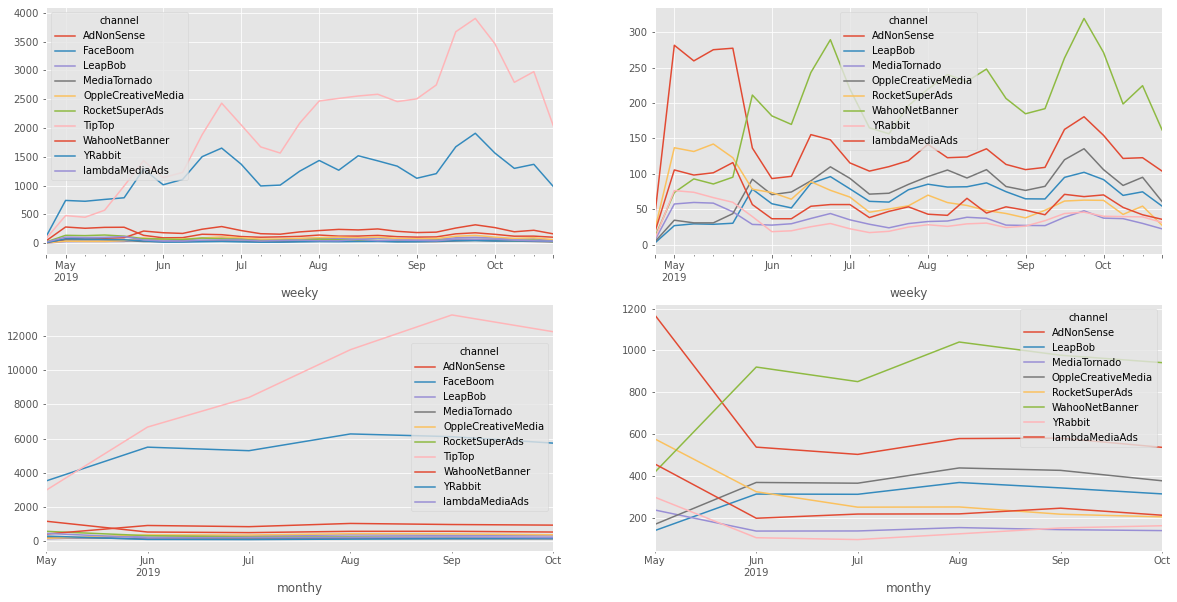

In [26]:
# собираем свод по неделям и свод по месяцам
look_at_me = ['TipTop', 'FaceBoom'] # топ каналы по затратам

c_weeky = costs.pivot_table(index='channel', columns='weeky', values='costs', aggfunc='sum')
c_monthy = costs.pivot_table(index='channel', columns='monthy', values='costs', aggfunc='sum')

c_weeky_bottom = c_weeky.query('channel != @look_at_me') # добавили срез без топ-каналов по неделям
c_monthy_bottom = c_monthy.query('channel != @look_at_me') # его же по месяцам

# рисуем графики
plt.figure(figsize=(20,10))
plt.style.use('ggplot')

ax_1 = plt.subplot(2,2,1)
c_weeky.T.plot(grid=True, ax=ax_1)

ax_2 = plt.subplot(2,2,2)
c_weeky_bottom.T.plot(grid=True, ax=ax_2)

ax_3 = plt.subplot(2,2,3)
c_monthy.T.plot(grid=True, ax=ax_3)

ax_4 = plt.subplot(2,2,4)
c_monthy_bottom.T.plot(grid=True, ax=ax_4);


**На графиках видим, что пик рекламной активности по самым дорогим каналам начинается с июня и достигает максимума к сентябрю (каналы TipTop, FaceBoom). На недельном графике видим, что самые активные недели продвижения - это третьи недели месяца (пики поседине ячейки)
<br>--------
<br> Посмотрим, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника:**

In [27]:
p_cac = profiles.pivot_table(index='channel', values='user_cost', aggfunc='mean').rename(columns={'user_cost': 'cac'})
p_cac.sort_values(by='cac', ascending=False).drop(index='organic').style.background_gradient(cmap='Greens')

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


<font color="DarkCyan">

**По таблице видим, что самый дорогой CAC имеют юзеры, пришедшие через канал TipTop, что логично с учетом общих затрат на канал (видели в предыдущем шаге, что более 50% бюджета было вложено именно в TipTop)**

### Анализ метрик

#### Общие метрики

##### LTV / ROI

<font color="DarkCyan">

**Проанализируем окупаемость рекламы c помощью графиков LTV / ROI и графиков динамики LTV / CAC / ROI.**
<br> За момент анализа берем 27 октября 2019, как последнюю дату привлечения пользователей. За горизонт анализа - 14 дней, так как задача - проверить окупаемость к этому периоду.
<br> Уровни пока оставляем пустыми, смотрим показатели по всем пользователям

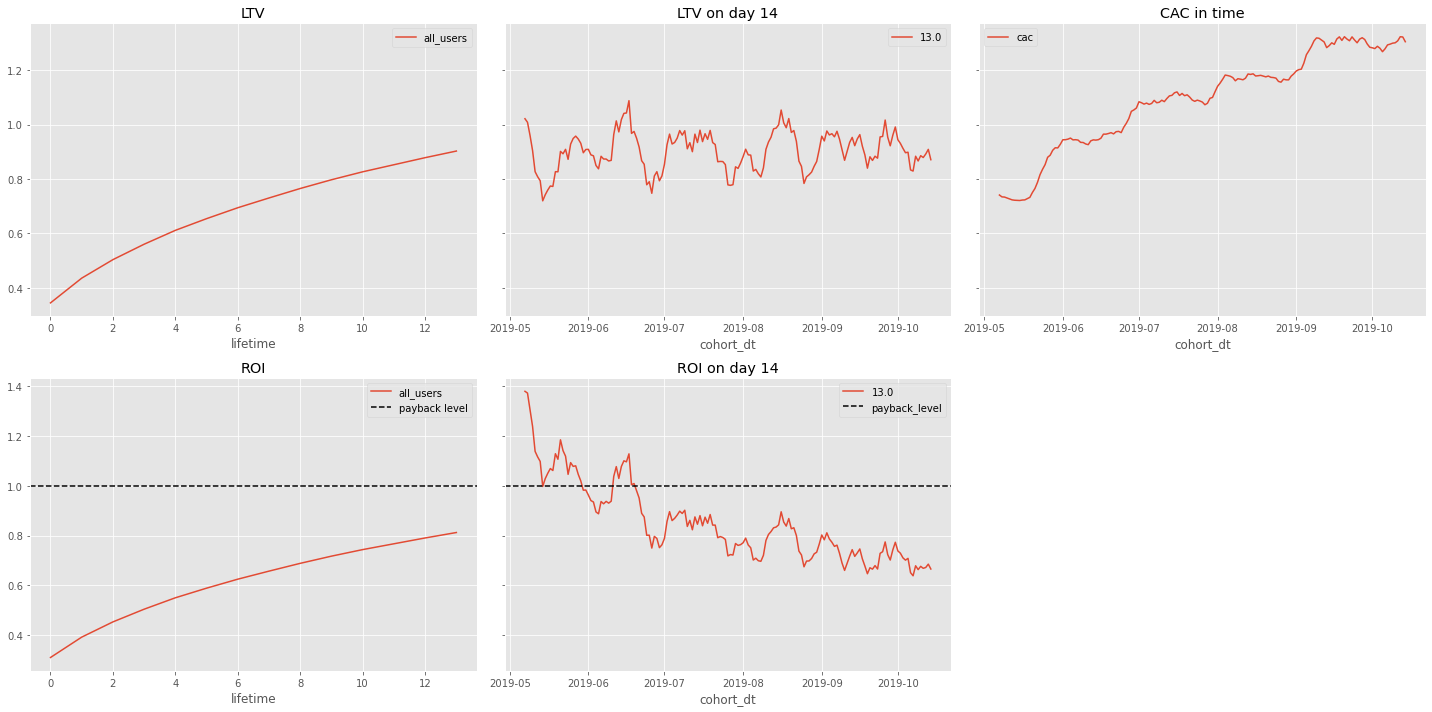

In [47]:
obs_dt = datetime(2019, 10, 27).date() #момент анализа
horizon = 14 # горизонт анализа

# поставим ignore_organic = True, тем самым выкинув органический трафик
ltv_raw, ltv_group, ltv_in_time, roi_group, roi_in_time = get_ltv(profiles, orders, obs_dt, horizon, levels=[], ignore_organic=True)
plot_ltv_roi(ltv_group, ltv_in_time, roi_group, roi_in_time, horizon, window=7)

<font color="DarkCyan"> 
    
**1| LTV стабилен, в течение горизонта анализа плавно восходит вверх (прим.: кривая расположена выше по сравнению с "размазанным" LTV по всем юзерам, в тч органическим. Т.е. можно сказать, что юзеры, привлеченные платно, имеют более высокий LTV)
<br> 2| LTV 14-го дня меняется от когорты к когорте, пики есть посередине месяцев (выше всех LTV по когортам, привлеченным в середине июня/июля/августа/сентября). В целом нет яркого тренда на снижение/повышение
<br> 3| CAC сильно растет с июня (месяц начала крупных кампаний по TipTop и FaceBoom), в октябре доходит до пиковых значений, сильно превосходя значения LTV по всем когортам - может быть связано с увеличением бюджета по каналу
<br> 4| ROI на уровне 0.8 к 14 дню - реклама не окупается
<br> 5| ROI 14-го дня имеет тренд на снижение: клиентов привлекаем очень дорого**

<br> -----
    <br> **Посмотрим, как дела с конверсией.**
    <br> Также посмотрим, на каких уровнях конверсия юзеров, привлеченных по рекламных каналам:

##### CR

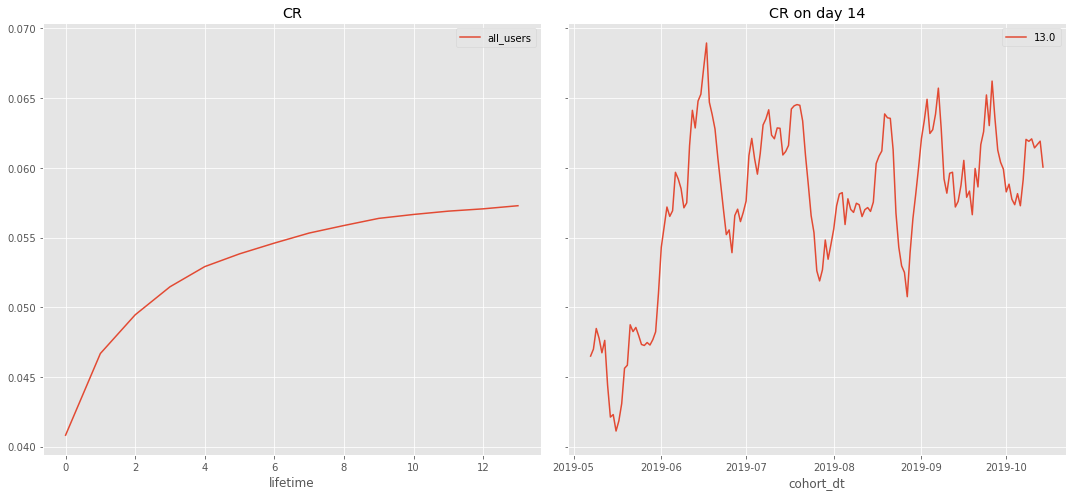

In [48]:
# CR по всем юзерам, не выкидываем органику
cr_raw, cr_group, cr_in_time = get_cr(profiles, orders, obs_dt, horizon, levels=[], ignore_organic=False)
plot_cr(cr_group, cr_in_time, horizon)

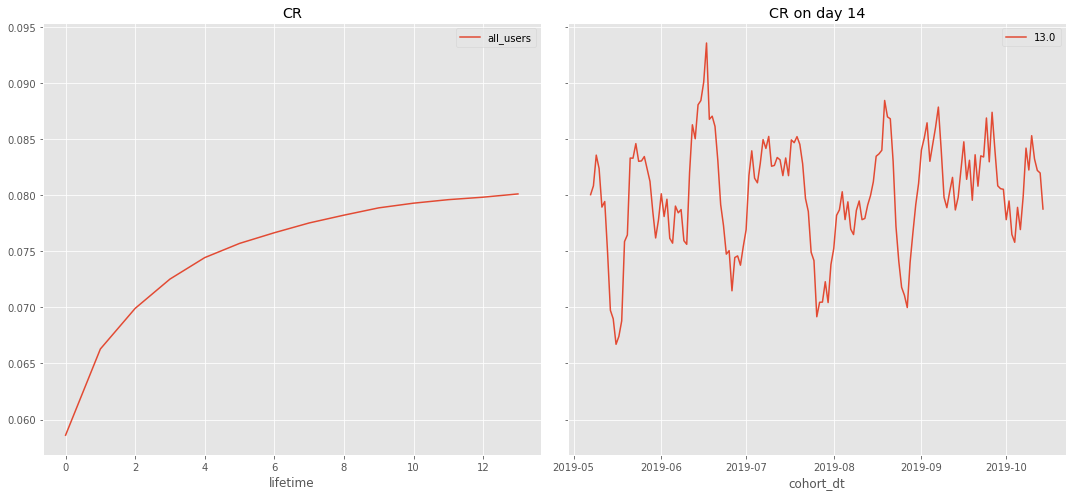

In [31]:
# CR без органики (поставили ignore_organic = True)
cr_raw, cr_group, cr_in_time = get_cr(profiles, orders, obs_dt, horizon, levels=[], ignore_organic=True)
plot_cr(cr_group, cr_in_time, horizon)

<font color="DarkCyan"> 

**Конверсия юзеров, привлеченных платно, выше "размазанной" (с органикой). Вместе с тем можно сказать, что очень небольшая доля пришедших конвертится в покупку (на 14 день лайфтайма "платные" превращаются в платящих менее чем в 10% случаев - а в большинстве когорт менее чем в 8%).**
    <br> Посмотрим, как дела с retention rate, также в разрезе всех юзеров + юзеров, привлеченных платно:

##### RR

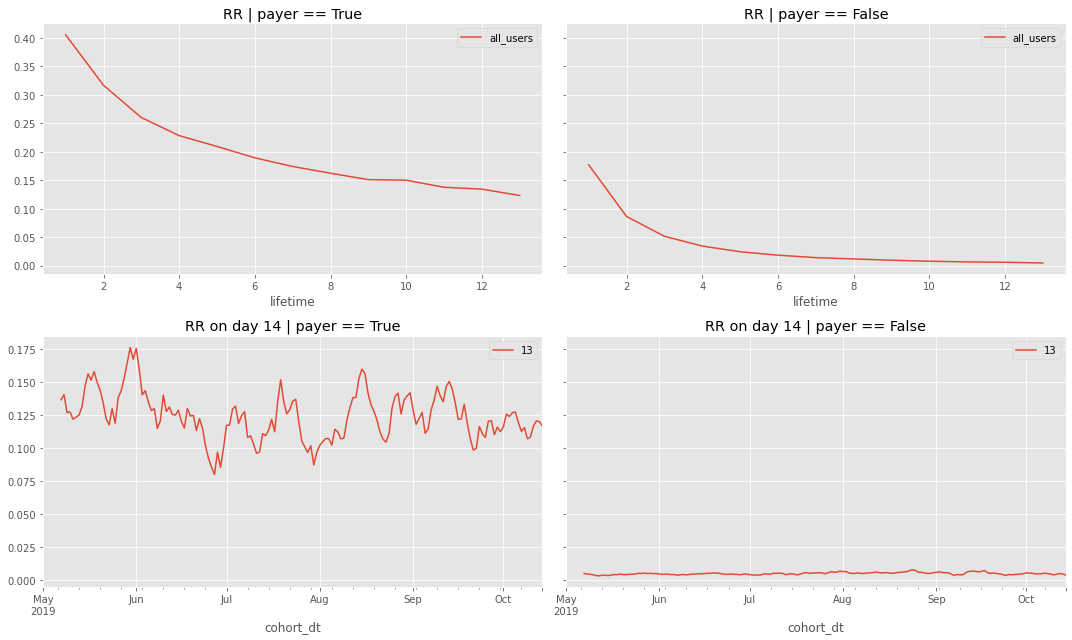

In [32]:
rr_raw, rr_group, rr_in_time = get_rr(profiles, visits, obs_dt, horizon, levels=[], ignore_organic=False)
plot_rr(rr_group, rr_in_time, horizon)

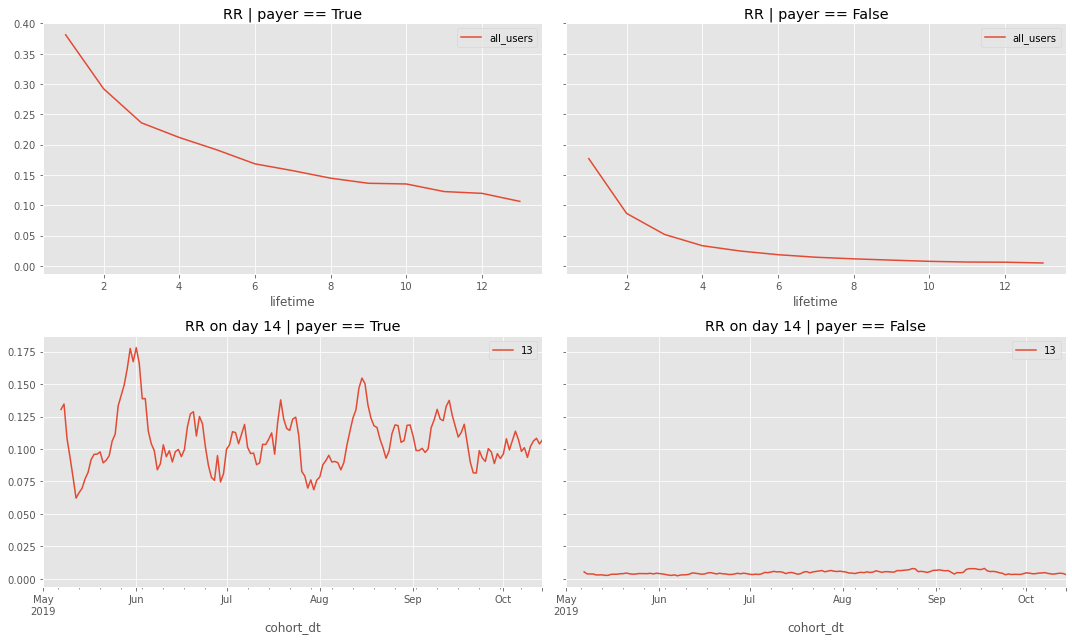

In [33]:
rr_raw, rr_group, rr_in_time = get_rr(profiles, visits, obs_dt, horizon, levels=[], ignore_organic=True)
plot_rr(rr_group, rr_in_time, horizon)

<font color="DarkCyan"> 

**Удержание платящих юзеров закономерно выше тех, кто не совершил покупку; при этом исключение органики не особо повлияло на общие графики RR - к 14 дню средний показатель по платящим падает до 10%. 
    <br>RR 14 дня невысокий, пик прошел в июне, в дальнейшем по периоду не поднимается выше 15% по отдельным когортам, в среднем держится в боковике между 7-12%.**
<br> **-----**
    <br> Посмотрим, как выглядят наши метрики в разных разрезах. При этом оставим выключенным органический трафик.

#### **LEVEL: DEVICE**

In [35]:
levels = ['device']

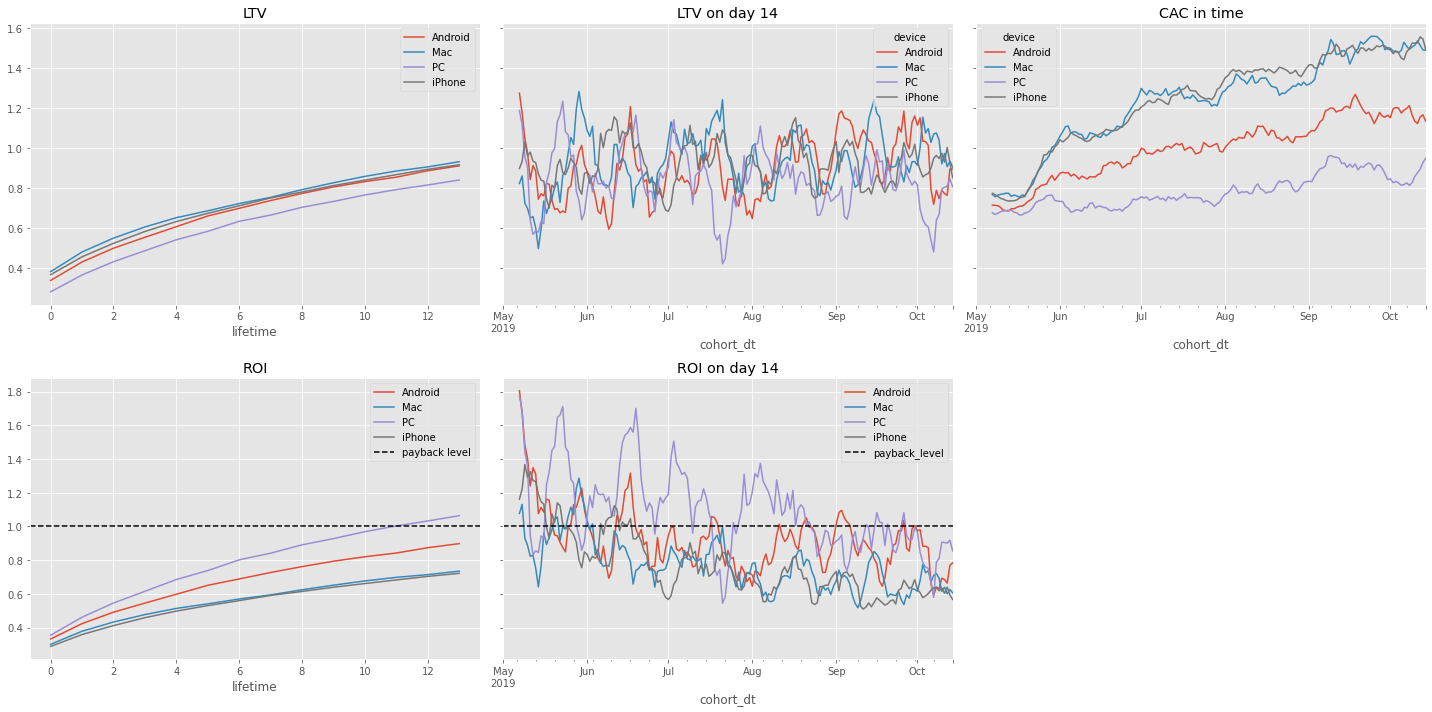

In [36]:
ltv_raw, ltv_group, ltv_in_time, roi_group, roi_in_time = get_ltv(profiles, orders, obs_dt, horizon, levels=levels, ignore_organic=True)
plot_ltv_roi(ltv_group, ltv_in_time, roi_group, roi_in_time, horizon)

<font color="c4063f"> 

**iPhone**
    <br>- показывает себя лучше остальных, тк меньше всего увеличивается CAC + iPhone единственная платформа, у которой окупается ROI (к 11 дню)
    <br>- тренд 14 дня ROI нисходящий, как и у остальных платформ, но падает слабее других, сохраняя пики окупаемости на протяжении почти всего обзорного периода
    <br>- с сентября заметен скачкообразный рост CAC. 
    <br>Итого по платформе можно сказать, что кач-во пользователей снижается, просто это выглядит не так плохо по сравнению с остальными.
<br>**Android**
    <br>- на 2 месте по "успешности" - чуть повыше линия общего LTV, при этом также повыше CAC (по сравнению с iPhone)
    <br>- вместе с тем платформа - наряду с Mac и PC - не вышла на уровень окупаемости к 14 дню обзорного периода, ROI 14 дня был выше уровня окупаемости только в считанных когортах
    <br>**Mac / PC** 
    <br>- по обеим платформам можно сказать о плохом качестве привлеченных юзеров - из-за очень высоких CAC и супер низкого ROI
<br>**-----
    <br>Посмотрим, что с конверсией в разрезе платформ:**

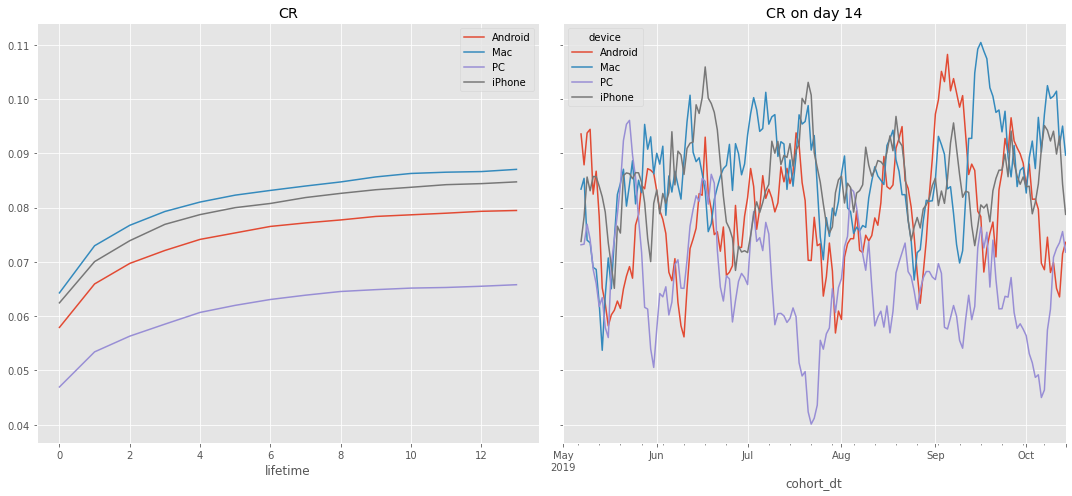

In [37]:
cr_raw, cr_group, cr_in_time = get_cr(profiles, orders, obs_dt, horizon, levels=levels, ignore_organic=True)
plot_cr(cr_group, cr_in_time, horizon, window=7)

<font color="c4063f"> 

**Mac/PC**
    <br>- имеют самый высокий CR - но незначительно выше остальных
    <br>- аналогично с CR 14 дня, больше всего наблюдается пиков именно по этим 2 платформам. Это может говорить о том, что юзеры, увидевшие рекламу в десктоп-версии чуть лучше реагируют на нее
<br>**Android**
    <br>- идёт в "середняках", уступая десктоп-платформам и обгоняя iPhone
    <br>**iPhone** 
    <br>- CR не поднимается выше 7% к дню 14, тренд становится почти горизонтальным. На графике с динамикой также наблюдаем линию платформы ниже остальных
<br>**-----
    <br>Посмотрим, что происходит с RR:**

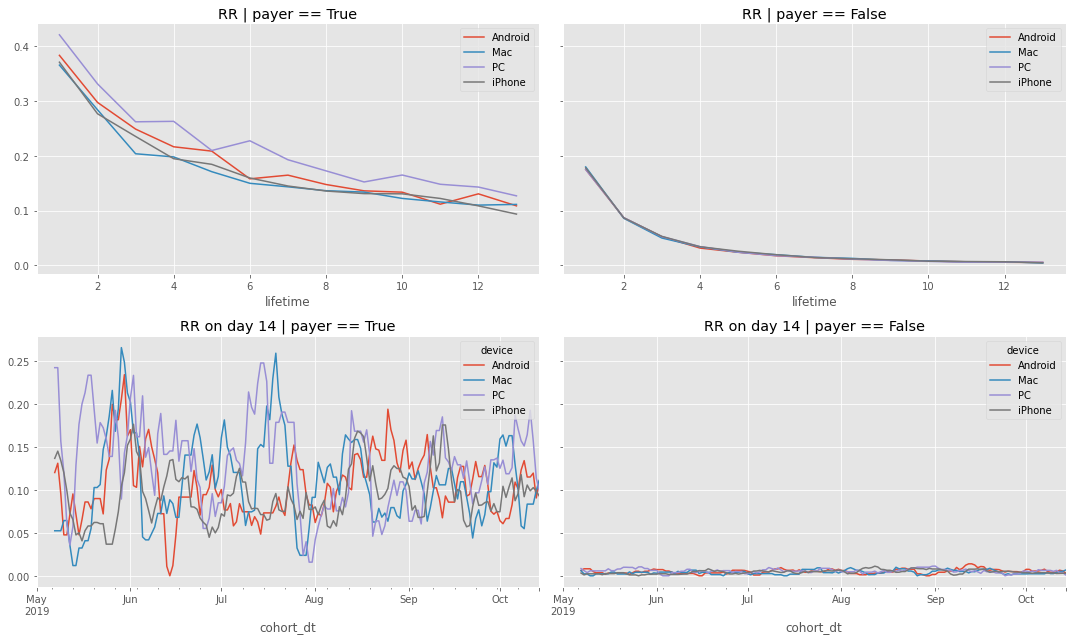

In [38]:
rr_raw, rr_group, rr_in_time = get_rr(profiles, visits, obs_dt, horizon, levels=levels, ignore_organic=True)
plot_rr(rr_group, rr_in_time, horizon, window=7)

<font color="c4063f"> 

**iPhone:** видим уровень RR чуть получше остальных, при этом у когорт в динамике начиная с августа RR 14 дня в приложении

###### Выводы:

<font color="c4063f"> 

**Итого по разрезу платформ можем сказать, что хоть данные и отличаются в зависимости от девайса - но не девайс оказал ключевое влияние на неокупаемость рекламы.**
    <br> Смотрим следующий разрез - по региону юзера.

#### **LEVEL: REGION**

In [39]:
levels = ['region']

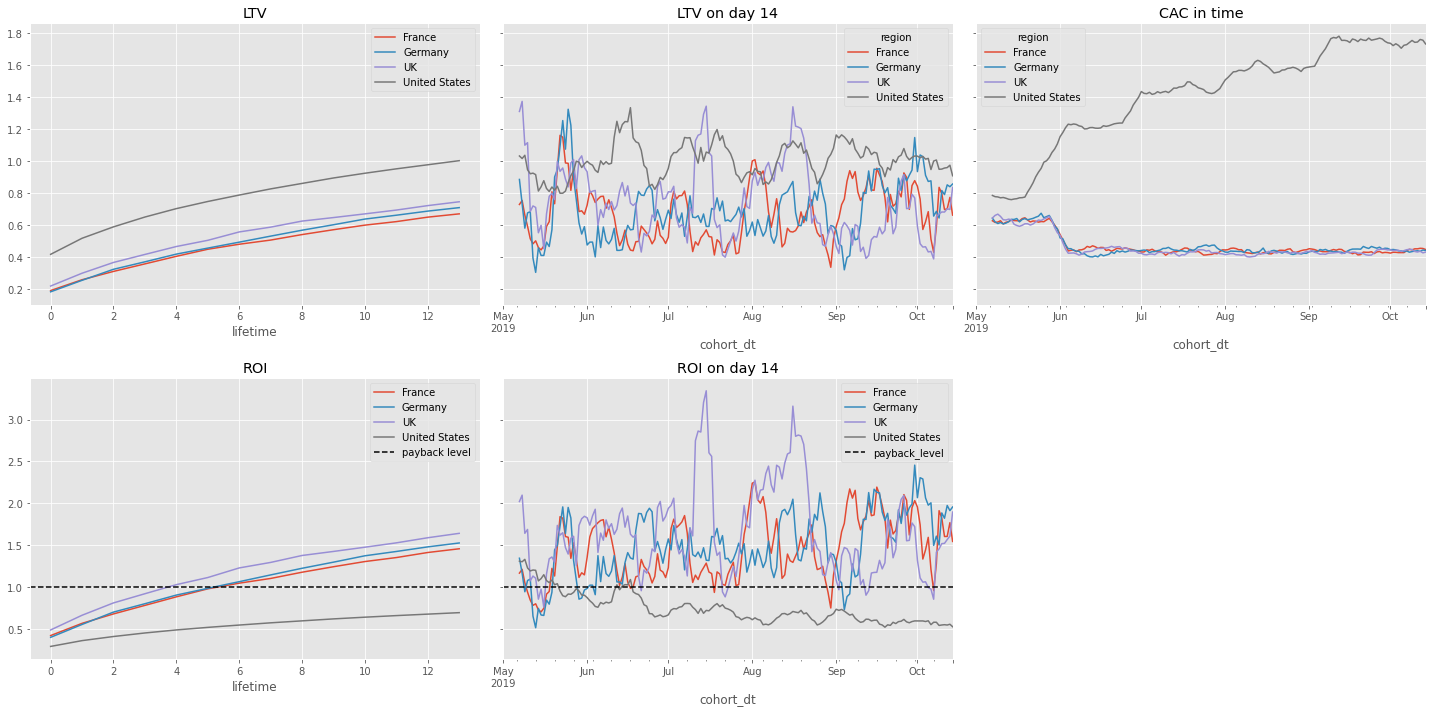

In [40]:
ltv_raw, ltv_group, ltv_in_time, roi_group, roi_in_time = get_ltv(profiles, orders, obs_dt, horizon, levels=levels, ignore_organic=True)
plot_ltv_roi(ltv_group, ltv_in_time, roi_group, roi_in_time, horizon)

<font color="Indigo"> 

**USA:** линия LTV выше остальных, вместе с тем на графике CAC видим, что юзеры именно этого региона взлетели по стоимости с июня. Из-за огромного CAC линия ROI ниже уровня окупаемости. ROI 14 дня в целом почти не поднимается выше уровня окупаемости.
    <br> **UK:** показывает себя лучше остальных - не такой высокий LTV по сравнению с США, вместе с тем низкий CAC, ROI выше окупаемости уже с 4 дня,  ROI 14 дня в основном выше уровня окупаемости
    <br>-----
    <br>**Посмотрим на CR в разрезе регионов:**

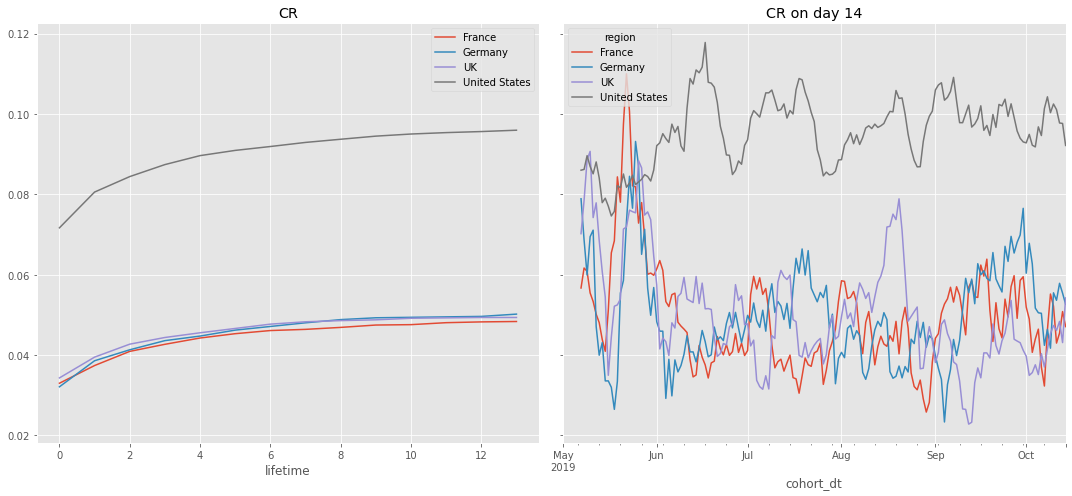

In [41]:
cr_raw, cr_group, cr_in_time = get_cr(profiles, orders, obs_dt, horizon, levels=levels, ignore_organic=True)
plot_cr(cr_group, cr_in_time, horizon, window=7)

<font color="Indigo"> 

**USA:** видим, что CR намного выше остальных регионов. К 14 дню около 10% юзеров становятся платящими
    <br> **Другие:** остальные регионы имеют низкий CR (в ~2 раза ниже США)
    <br>-----
    <br>**Посмотрим на RR для финальных выводов по разрезу:**

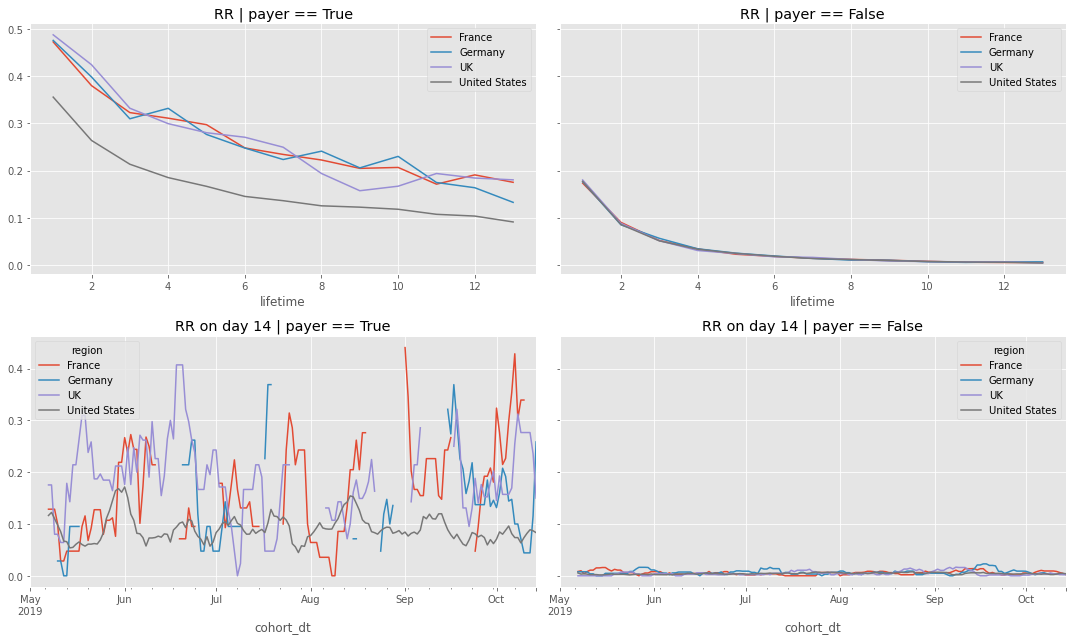

In [42]:
rr_raw, rr_group, rr_in_time = get_rr(profiles, visits, obs_dt, horizon, levels=levels, ignore_organic=True)
plot_rr(rr_group, rr_in_time, horizon, window=7)

<font color="Indigo"> 

Обращаем внимание только на графики платящих юзеров (payer == True)
<br>**USA:** низкий RR. Даже на старте лайфтаймов около 35% юзеров возвращаются в приложение.
    <br> **UK:** юзеры из этого региона снова ведут себя лучше остальных, имея более высокий RR - как в общей линии, так и в динамике 14 дня
    <br> **France:** по данному региону также можно отметить относительно высокий RR на 14 день

###### Выводы:

<font color="Indigo"> 

**USA:**
<br>- юзеры бодрее превращаются в покупателей, вместе с тем "отваливаясь" быстрее остальных по RR 
<br>- более высокий LTV нивелируется очень высоким CAC, не окупая инвестиции в рекламу по данному региону
<br>- реклама не эффективна в регионе - очень большие затраты против низкого кач-ва пользователей
<br>
<br>**UK:**
    <br>- регион с самым высоким ROI - юзеры окупаются уже на 4 день
    <br>- лучше показатель RR, невысокий CAC; вместе с тем - низкие CR и LTV
    <br>- реклама в регионе также неэффективна, но по другим признакам - привлекаются юзеры качеством получше США, но небольшая доля из них конвертится в покупателей.

#### **LEVEL: CHANNEL**

In [43]:
levels = ['channel']

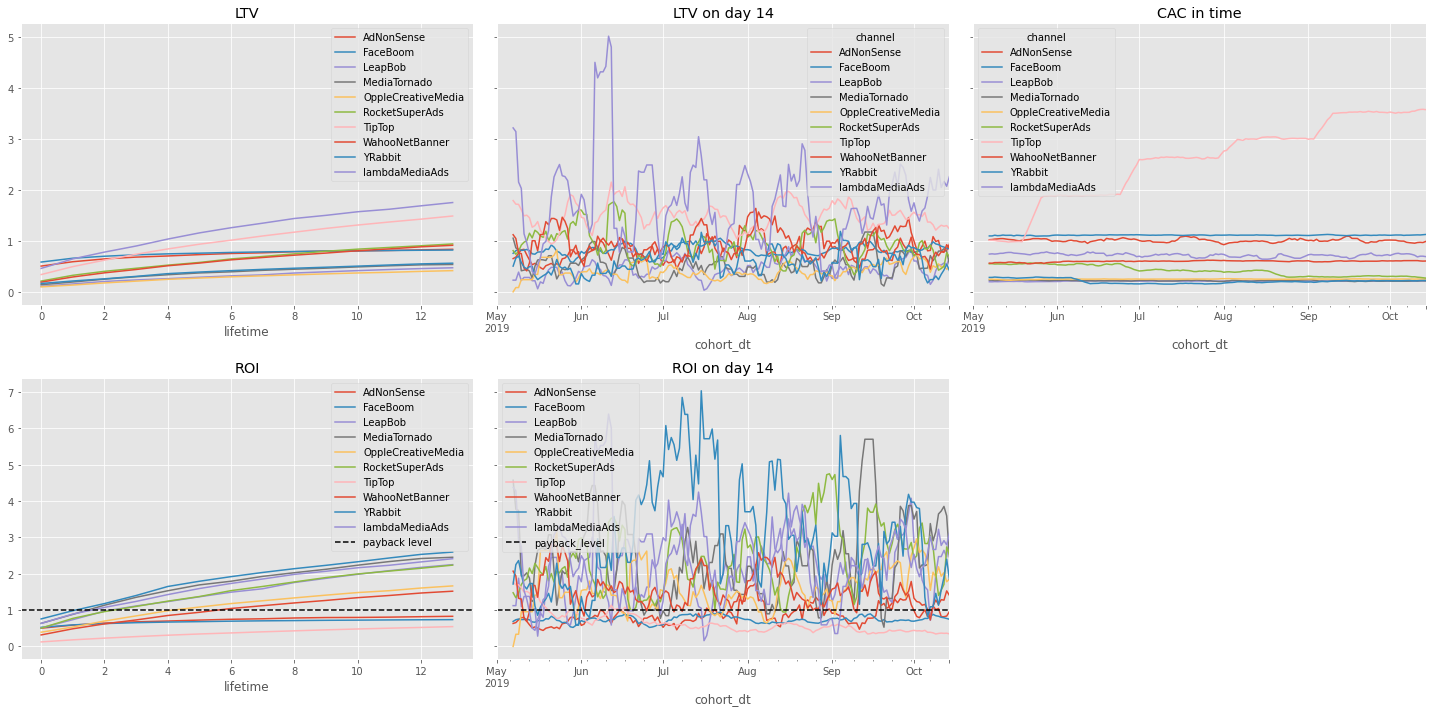

In [44]:
ltv_raw, ltv_group, ltv_in_time, roi_group, roi_in_time = get_ltv(profiles, orders, obs_dt, horizon, levels=levels, ignore_organic=True)
plot_ltv_roi(ltv_group, ltv_in_time, roi_group, roi_in_time, horizon)

<font color="DarkGreen"> 

**Смотреть графики по всем каналам неудобно. Фильтранем сет по выделяющимся каналам / переиспользуем уже написанную функцию для группировки / построим графики заново:**

In [45]:
# создали список с интересующими каналами
look_at_me = ['LeapBob', 'TipTop', 'FaceBoom', 'YRabbit', 'MediaTornado', 'AdNonSense']
ltv_raw_f = ltv_raw[ltv_raw['channel'].isin(look_at_me)]

# переиспользуем синтаксис уже созданной ранее функции - меняем название, чтобы иметь доступ к предыдущей версии со всеми каналами
def group_ltv_lev_f(df, levs, horizon):
        ltv_lev = df.pivot_table(index=levs, columns='lifetime', values='revenue', aggfunc='sum')
        ltv_lev = ltv_lev.fillna(0).cumsum(axis=1)
        
        cohorts = (df.groupby(levs)
                   .agg({'id': 'nunique'})
                   .rename(columns={'id': 'cohort_size'}))
        
        ltv_lev = cohorts.merge(ltv_lev, on=levs, how='left').fillna(0)
        ltv_lev = ltv_lev.div(ltv_lev['cohort_size'], axis=0)
        ltv_lev = ltv_lev[['cohort_size'] + list(range(horizon))]
        ltv_lev['cohort_size'] = cohorts
        
        cac = df[['id', 'user_cost'] + levs].drop_duplicates()
        cac = cac.groupby(levs).agg({'user_cost': 'mean'}).rename(columns={'user_cost': 'cac'})
        
        roi = ltv_lev.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohorts
        roi['cac'] = cac['cac']
        
        roi = roi[['cohort_size', 'cac'] + list(range(horizon))]
        
        return ltv_lev, roi

ltv_group_f, roi_group_f = group_ltv_lev_f(ltv_raw_f, levels, horizon)
ltv_in_time_f, roi_in_time_f = group_ltv_lev_f(ltv_raw_f, levels+['dt'], horizon)

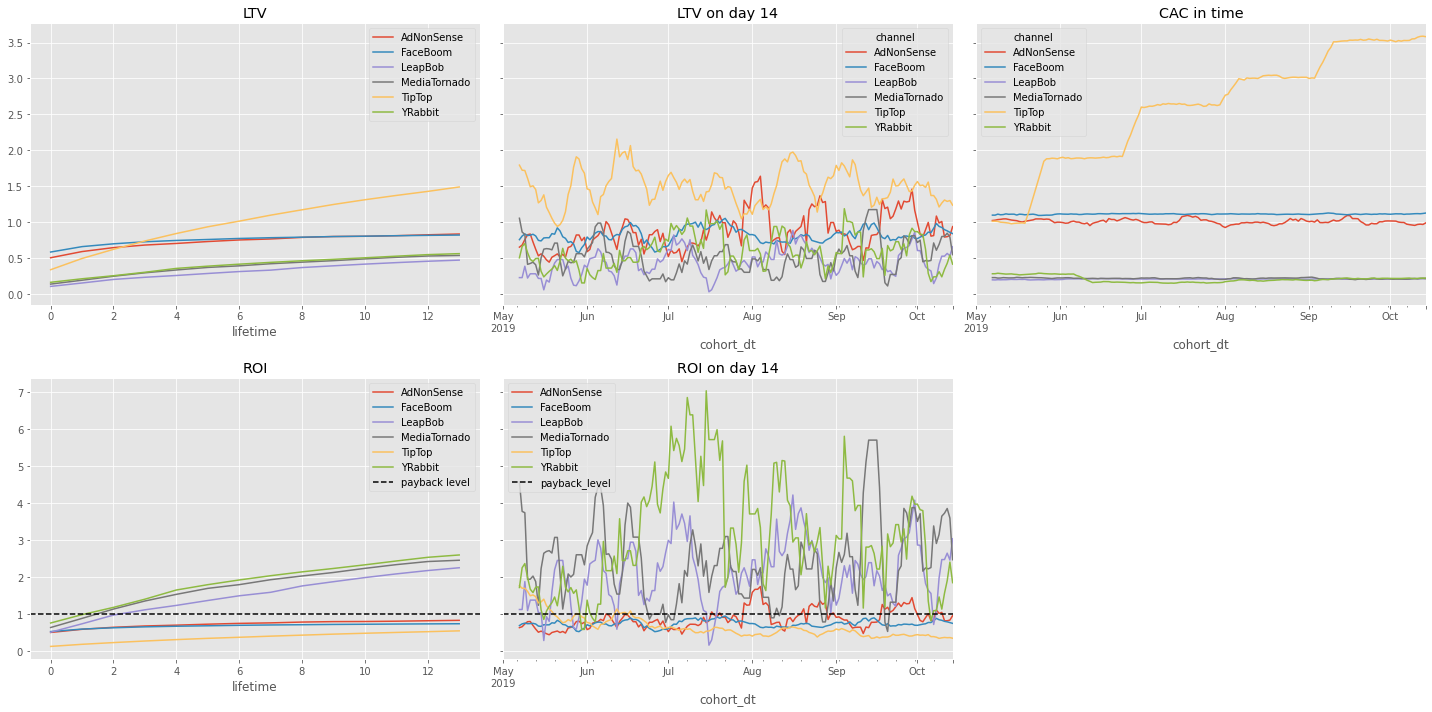

In [46]:
# строим графики заново
plot_ltv_roi(ltv_group_f, ltv_in_time_f, roi_group_f, roi_in_time_f, horizon)

<font color="DarkGreen"> 

**TipTop:** самый высокий LTV и вместе с тем взрывной рост CAC с июня - видно, что в кампанию с каждым месяцам вливали все больше бюджета. При этом на графиках ROI видим, что канал очень далек от уровня окупаемости - как на 14 день, так и в принципе - судя по горизонтальному тренду
    <br> **FaceBoom:** второй по уровню расходов канал - видим "ровный" CAC, такой же "ровный" LTV и неокупаемость инвестиций
    <br> **YRabbit / MediaTornado / LeapBob:** ROI выше уровня окупаемости уже на 2 день, ROI когорт 14 дня также выше уровня, очень низкий CAC. Кампании хорошие - даже с учетом низкого LTV.

###### Выводы:

<font color="DarkCyan"> 

**1| Реклама не окупается
<br>2| Особое негативное влияние оказывает реклама в США и каналы TipTop и FaceBoom (к примеру YRabbit отработал отлично, но не его выбрали для вливания бюджета с июня)
<br>3| Проблемы окупаемости вызваны в первую очередь неправильным выбором каналов (с 1 месяца могло стать понятно, что реклама в каналах из п.2 отрабатывает неэффективно, но ее не свернули, не перераспределили бюджет) + во вторую плохим качеством привлеченных юзеров (как минимум это можно сказать по низким RR/CR)
<br>---
<br> Промежуточные рекомендации:
    <br>- на будущее: строить аналитику на начальном этапе рекламных кампаний (лучше в дашбордах) + пилотировать кампании до масштабирования + не продолжать кампании, если видите ROI как в графиках выше
    <br>- в данный момент: свернуть кампании в каналах TipTop/FaceBoom, как в самых дорогих; переориентировать бюджет региона США на каналы YRabbit/MediaTornado**

### Итоговый вывод

<font color="DarkCyan"> 
    
**Итого причины неэффективности кампаний:
  <br>- отсутствие пилотирования кампаний и нерелеватное расходование бюджета на неэффективные каналы (сделали вывод по скорости нарастания бюджетов)
  <br>- в целом плохо настроенные кампании (сделали вывод по слабой конверсии юзеров в покупателей)
  <br>- отсутствие онбординга и дальнейшего развития платных пользователей (сделали вывод по слабому retention rate)    
<br>Итоговые рекомендации:
<br>- по маркетингу:** перераспределить рекламный бюджет, начиная с ноября, оставив минимальную долю в каналах TipTop/FaceBoom, повысив объем бюджета в каналах YRabbit / MediaTornado / LeapBob + провести исследование эффективности рекламы (CR надо повышать)
<br>**- по продукту:** проверить отклик на онбординг + проверить сам CJM (RR надо повышать)
<br>**- по аналитике:** построить рекламную отчетность в дашбордах для оперативного отслеживания метрик и принятие решений